In [ ]:
%load_ext autoreload
%autoreload 2


In [ ]:
import btk
from galcheat.utilities import mean_sky_level
import matplotlib.pyplot as plt
import numpy as np

from btk.measure import get_snr

## BTK dataset

In [ ]:
max_n_sources = 1
min_n_sources = 1 # always once source
stamp_size =  53 * 0.2 # arcsecs
max_shift = 0.0 # shift from center (so centered)
seed = 0

catalog = btk.catalog.CatsimCatalog.from_file('../../../data/OneDegSq.fits')
catalog.get_raw_catalog()['i_ab'].min(), catalog.get_raw_catalog()['i_ab'].max()

(14.3246593475, 29.9895343781)

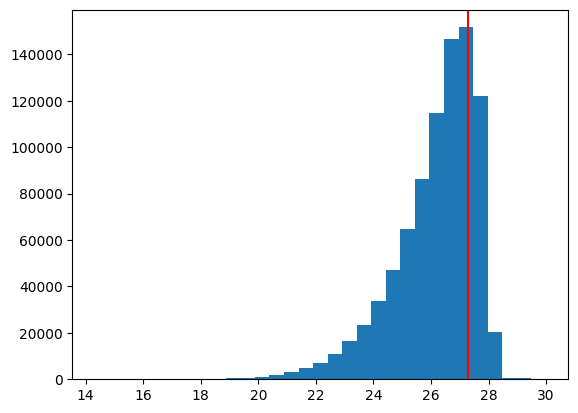

In [ ]:
cat = catalog.get_raw_catalog()
plt.hist(cat['i_ab'], bins=31)
plt.axvline(27.3, color='r')

In [ ]:
ra = cat['ra']
ra = (ra + ra.mean()) % 360
ra.max() - ra.min()

0.9999989267439844

In [ ]:
len(cat[cat['i_ab'] < 27.3]) / (3600) # 1 sq deg

185.13194444444446

In [ ]:
sampling_function = btk.sampling_functions.DefaultSampling(
    max_number=max_n_sources,
    min_number=min_n_sources,
    stamp_size=stamp_size, 
    max_shift=max_shift, 
    min_mag = 0,  # min mag in i-band is 14.32
    max_mag = 27.3, # see document for high level responses 
    seed = seed)


In [ ]:
LSST = btk.survey.get_surveys('LSST')
i_filt = LSST.get_filter('i')

In [ ]:
# get sky level in e- counts 
sky_level = mean_sky_level('LSST', 'i').to_value('electron')

In [ ]:
i_filt.psf_fwhm

<Quantity 0.79 arcsec>

In [ ]:

batch_size = 100

draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    LSST,
    batch_size=batch_size,
    stamp_size=stamp_size,
    njobs=1,
    add_noise="all",
    seed=seed, # use same seed here
)


In [ ]:
batch = next(draw_generator)
batch

BlendBatch(survey_name=LSST, 
	 blend_images: np.ndarray, shape [100, 6, 53, 53]
	 isolated_images: np.ndarray, shape [100, 1, 6, 53, 53]
	 catalog_list: list of <class 'astropy.table.table.Table'>, size 100
	 psfs: list of <class 'galsim.gsobject.GSObject'>, size 6
	 wcs: <class 'astropy.wcs.wcs.WCS'>)

In [ ]:
for p in batch.catalog_list[0].columns:
    print(p)

galtileid
ra
dec
redshift
fluxnorm_bulge
fluxnorm_disk
fluxnorm_agn
a_b
a_d
b_b
b_d
pa_bulge
pa_disk
u_ab
g_ab
r_ab
i_ab
z_ab
y_ab
x_peak
y_peak
btk_rotation
not_drawn_u
not_drawn_g
not_drawn_r
not_drawn_i
not_drawn_z
not_drawn_y


In [ ]:
d = dict(batch.catalog_list[0])
for p in d:
    print(d[p].value)

[402705367267]
[0.]
[0.]
[0.31423011]
[0.]
[2.17991994e-18]
[0.]
[0.]
[0.92527241]
[0.]
[0.62053549]
[0.]
[339.92495727]
[25.91155052]
[25.8383522]
[25.65806389]
[25.69213867]
[25.73265648]
[25.75240326]
[26.]
[26.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


In [ ]:
snrs = get_snr(batch.isolated_images[:, 0, 3], sky_level)

In [ ]:
a = np.array([1,2,3])
b = np.array([4,5,6])
np.vstack((a,b)).T

array([[1, 4],
       [2, 5],
       [3, 6]])

27.0603847504 3.0134590567345487


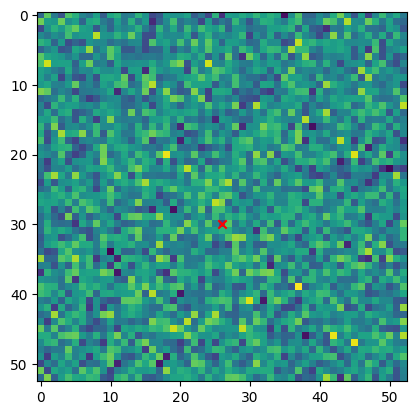

In [ ]:
idx = np.random.randint(0, 100)
plt.imshow(batch.blend_images[idx, 3]) # i-band, is indx = 3
plt.scatter(26, 30, color='r', marker='x')
print(batch.catalog_list[idx]['i_ab'].value.item(), snrs[idx])

(array([4.00000e+00, 7.00000e+00, 1.30000e+01, 1.90000e+01, 5.70000e+01,
        1.17000e+02, 2.06000e+02, 4.18000e+02, 8.79000e+02, 1.59600e+03,
        2.98700e+03, 5.26700e+03, 9.14900e+03, 1.50610e+04, 2.41320e+04,
        3.79030e+04, 5.75850e+04, 8.56110e+04, 1.21414e+05, 1.69334e+05,
        1.89156e+05, 1.30416e+05, 6.35000e+03, 4.45000e+02, 3.76000e+02]),
 array([14.32465935, 14.95125435, 15.57784935, 16.20444435, 16.83103935,
        17.45763435, 18.08422935, 18.71082436, 19.33741936, 19.96401436,
        20.59060936, 21.21720436, 21.84379936, 22.47039436, 23.09698936,
        23.72358437, 24.35017937, 24.97677437, 25.60336937, 26.22996437,
        26.85655937, 27.48315437, 28.10974937, 28.73634438, 29.36293938,
        29.98953438]),
 <BarContainer object of 25 artists>)

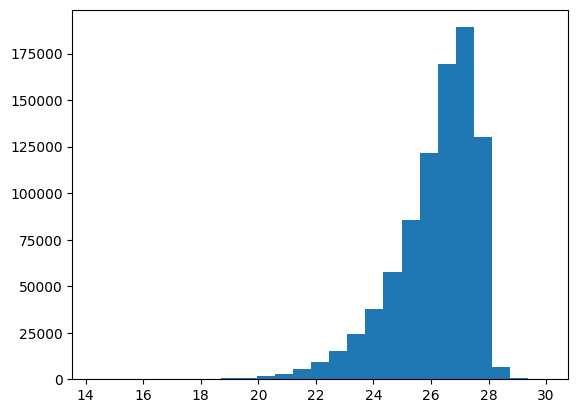

In [ ]:
plt.hist(catalog.get_raw_catalog()['i_ab'], bins=25)

In [ ]:
batch.catalog_list[0]['i_ab'].value.item()

24.3130187988

## stars

In [ ]:
from astropy.table import Table

star_data = "../../../data/stars_med_june2018.fits"
stars = Table.read(star_data)

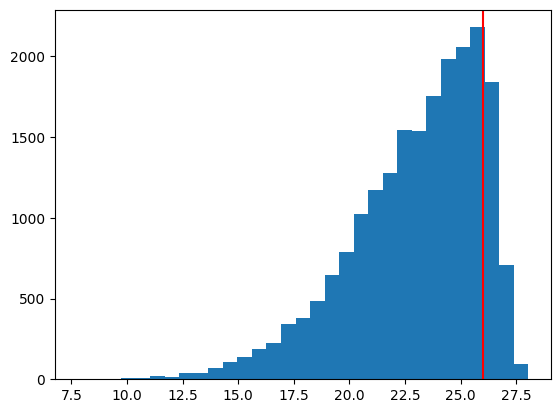

In [ ]:
plt.hist(stars['i_ab'], bins=31)
plt.axvline(26.0, color='r')

## Poisson distribution

In [ ]:
import numpy as np 
import scipy.special
import matplotlib.pyplot as plt

density = 185 
exp_count = 30
x = np.arange(0, 30)
px = (exp_count ** x) * np.exp(-exp_count) / scipy.special.factorial(x)

In [ ]:
scipy.special.factorial(x)

array([1.00000000e+00, 1.00000000e+00, 2.00000000e+00, 6.00000000e+00,
       2.40000000e+01, 1.20000000e+02, 7.20000000e+02, 5.04000000e+03,
       4.03200000e+04, 3.62880000e+05, 3.62880000e+06, 3.99168000e+07,
       4.79001600e+08, 6.22702080e+09, 8.71782912e+10, 1.30767437e+12,
       2.09227899e+13, 3.55687428e+14, 6.40237371e+15, 1.21645100e+17,
       2.43290201e+18, 5.10909422e+19, 1.12400073e+21, 2.58520167e+22,
       6.20448402e+23, 1.55112100e+25, 4.03291461e+26, 1.08888695e+28,
       3.04888345e+29, 8.84176199e+30])

In [ ]:
np.random.poisson(exp_count)

34

## test new BLISS datasets

In [ ]:
from bliss.datasets.single_galaxies import SingleGalsimGalaxies

single_dataset = SingleGalsimGalaxies(catalog_file='../../../data/OneDegSq.fits', num_workers=1, batch_size=10, n_batches=1, slen=88, seed=0)

28.596206531943864


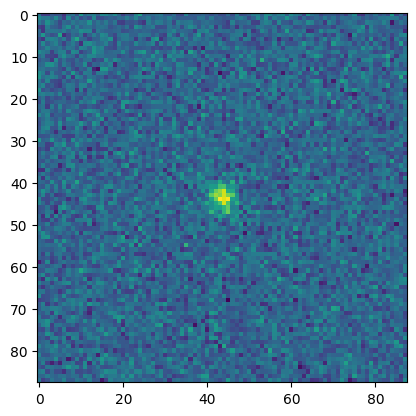

In [ ]:
batch = single_dataset[0]
plt.imshow(batch['images'][0])
print(batch['snr'])